#### Can Elbirlik celbirlik@gmail.com

In [1]:
def compute_iou(box, boxes, box_area, boxes_area):

    y1 = np.maximum(box[0], boxes[:, 0])
    y2 = np.minimum(box[2], boxes[:, 2])
    x1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[3], boxes[:, 3])
    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    union = box_area + boxes_area[:] - intersection[:]
    iou = intersection / union
    return iou


def compute_overlaps(boxes1, boxes2):

    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])


    overlaps = np.zeros((boxes1.shape[0], boxes2.shape[0]))
    for i in range(overlaps.shape[1]):
        box2 = boxes2[i]
        overlaps[:, i] = compute_iou(box2, boxes1, area2[i], area1)
    return overlaps

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import itertools
import pandas as pd
import time
import cv2
import os
from tqdm import tqdm
import csv


## Requirements: 
#### -To evaluate any model, bounding boxes of ground truths and predictions must be provided in seperate text files. 
#### -The rows must be ordered by image ids
#### -Exact format format of the text files should be like this:
#### -image_id,class_id,bounding_box_coordinates(y1,x1,y2,x2). Example:
####  0,1,[216 400 656 644]
####  1,44,[319 672 837 978]
####  2,1,[435 150 670 250]



###  ---**To obtain quick evaluations** on COCO groundtruths, all that is needed to be changed is "preds.txt" file in vallogs directory.

### 1) Set Directories to where you put your text files in. 

In [9]:
train_dir="trainlogs"
val_dir="vallogs"
prediction_file="preds.txt"
gtruth_file="gt.txt"

#### Total image numbers to be evaluated:

In [3]:

val_total_image=40136

In [4]:
train_total_image=82080

####  Class Names as in the original dataset. Default one is for COCO

In [6]:
class_names=['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

#### Text reading function

In [7]:
import csv

def text_reader(folder,name):
    print("Reading the file:")
    predictionlist=[]
    with open(os.path.join(folder,name),newline='') as f:
        rows=csv.reader(f)
        for row in rows:
            predictionlist.append(row)
    predictions=[]
    for i in tqdm(range(len(predictionlist))):
        img_id=eval(predictionlist[i][0])
        class_id=eval(predictionlist[i][1])
        bbox=(predictionlist[i][2][1:-1]).split(' ')
        j_list=[]
        for i in bbox:
            k=[]
            if not i=='':
                   j_list.append(i)
        bbox=[eval(i) for i in j_list]
        predictions.append([img_id,class_id,bbox])
    return predictions

### Read GT and Prediction files.

In [10]:

preds=text_reader(val_dir,prediction_file)

Reading the file:


100%|██████████| 445043/445043 [00:14<00:00, 30220.24it/s]


In [11]:
gts=text_reader(val_dir,gtruth_file)

Reading the file:


100%|██████████| 291871/291871 [00:10<00:00, 28928.16it/s]


In [13]:
def get_container(liste,upto):
    last_n=0
    container=[]
    for index,row in enumerate(liste[:upto]):
        if row[0]==last_n:
            continue
        else:   
            container.append([last_n,index])
            last_n=row[0]
    return container

In [14]:
gt_container=get_container(gts,len(gts))

In [15]:
pred_container=get_container(preds,len(preds))

In [16]:
keyp=0
def load_boxes(im_id,container,datas,val=False):
    global keyp
    if val==True:
        key=keyp
    elif val==False:
        key=0
    if(im_id!=container[im_id-key][0]):
        print("No predictions in image:"+str(im_id))
        keyp+=1
        return [[0,0,0,0]],['BG']
    last=container[im_id-key][1]
    assert im_id>=0
    if im_id>0:
        first=container[im_id-1-key][1]
    else:
        first=0
    class_id_list=[]
    box_list=[]
    
    for data in datas[first:last]:
        class_id=data[1]
        box=data[2]
        class_id_list.append(class_id)
        box_list.append(box)
    return box_list,class_id_list
    
    
    
    

In [17]:
def evaluate(size,threshold,gt_container,pred_container,preds,gts):
    gtruths = []
    predictions = []    
    for i in tqdm(range(size)):
        preda_bbx,pred_classes=load_boxes(i,pred_container,preds,val=True)
        gta_bbx,gt_classes=load_boxes(i,gt_container,gts)
        overlaps=compute_overlaps(np.array(preda_bbx),np.array(gta_bbx))

        match_count=0
       # discarded_2nd_bb=[]

        try:
            for  j in range(overlaps.shape[1]):
                if overlaps.shape[0]>0:
                    if overlaps[(overlaps[:, j].argmax()),j] > threshold:
                        gtruths.append((gt_classes[j]))
                        predictions.append(pred_classes[overlaps[:,j].argmax()])
                        ;
                        
                        
        except:
            print(overlaps.shape[0],overlaps.shape[1])
    return gtruths,predictions

In [18]:
keyp=0
iou_threshold=0.5
a,s=evaluate(val_total_image,iou_threshold,gt_container,pred_container,preds,gts)

 10%|█         | 4146/40136 [00:00<00:05, 6900.15it/s]

No predictions in image:2734


 34%|███▎      | 13535/40136 [00:01<00:03, 7070.03it/s]

No predictions in image:12496


 60%|██████    | 24270/40136 [00:03<00:02, 7036.72it/s]

No predictions in image:22879


100%|██████████| 40136/40136 [00:05<00:00, 7004.27it/s]


In [19]:
cfmatrix=confusion_matrix(a,s)

#### Normalised Confusion Matrix

In [20]:
def percentage_plot_cfmatrix(confusion_matrix, class_names ,threshold,figsize = (40,40), fontsize=8):
    confusion_matrix=cfmatrix/cfmatrix.sum(axis=1,keepdims=True)
    df_cm = pd.DataFrame(
        (100*confusion_matrix), index=class_names[1:], columns=class_names[1:], 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sn.heatmap(df_cm, annot=True, cmap="YlGnBu", fmt='.1f',annot_kws={"size": 10})
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("ConfusionMatrix@threshold:"+str(threshold)+".png")
    return fig

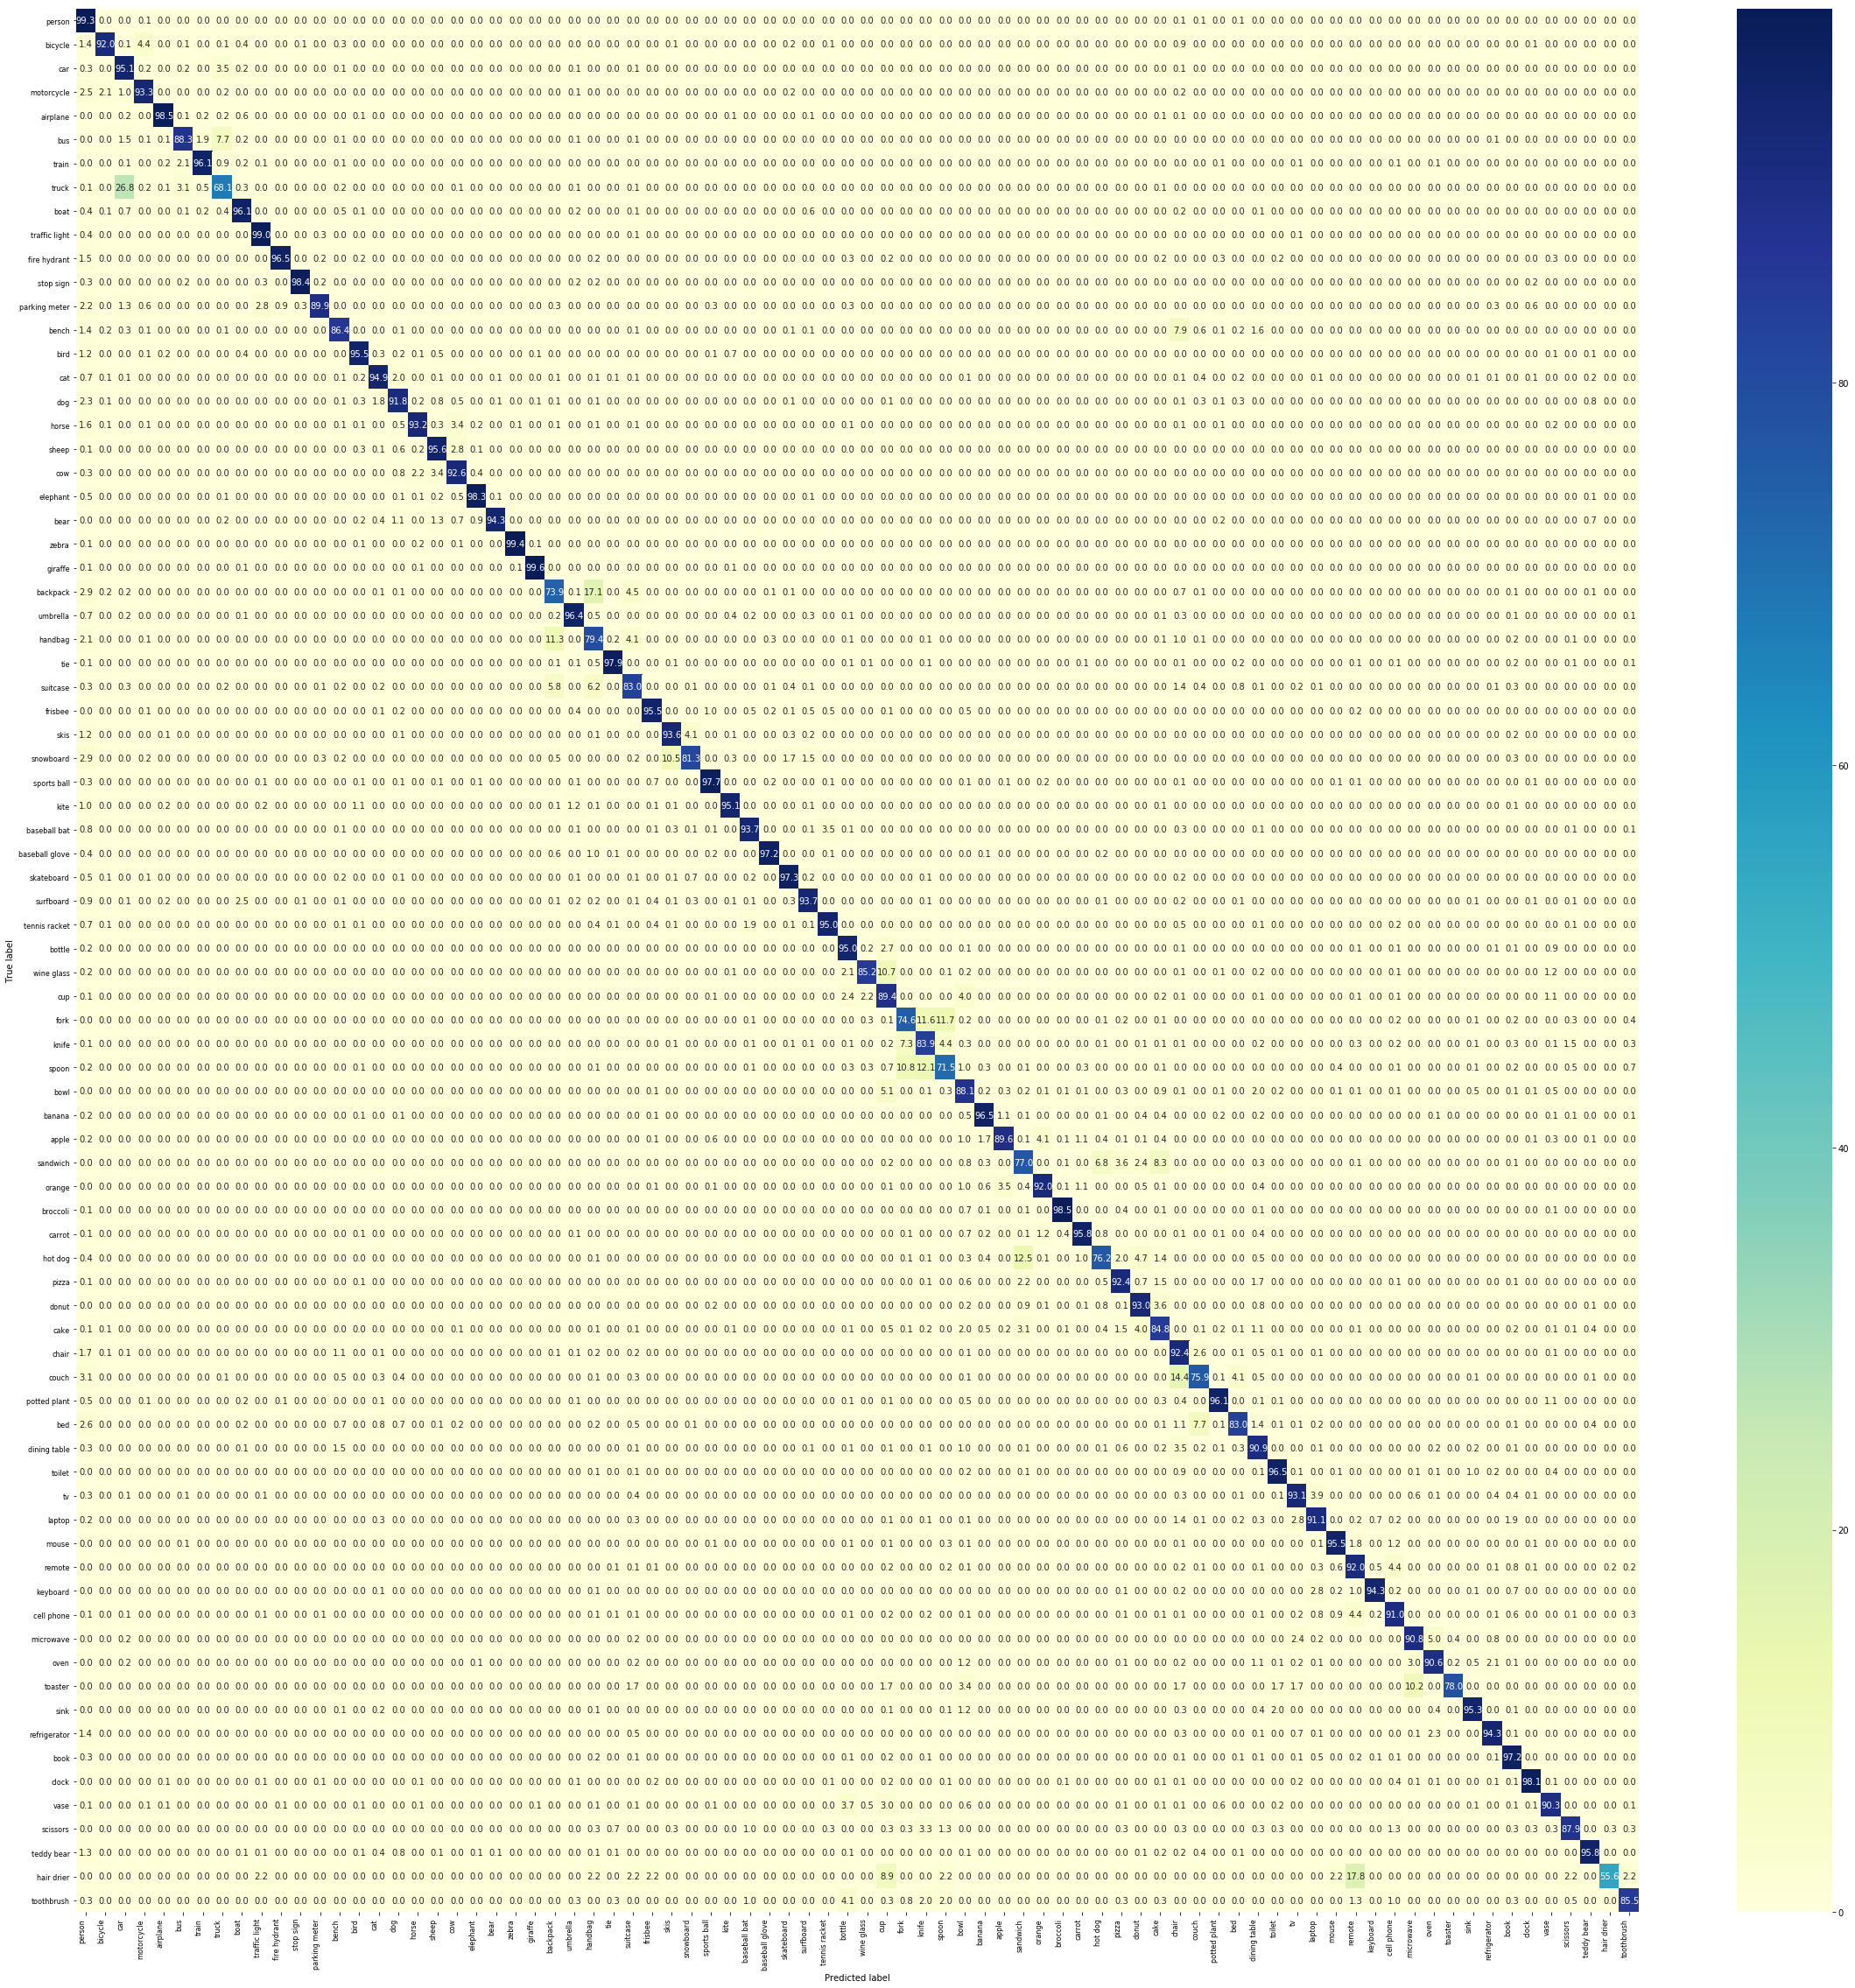

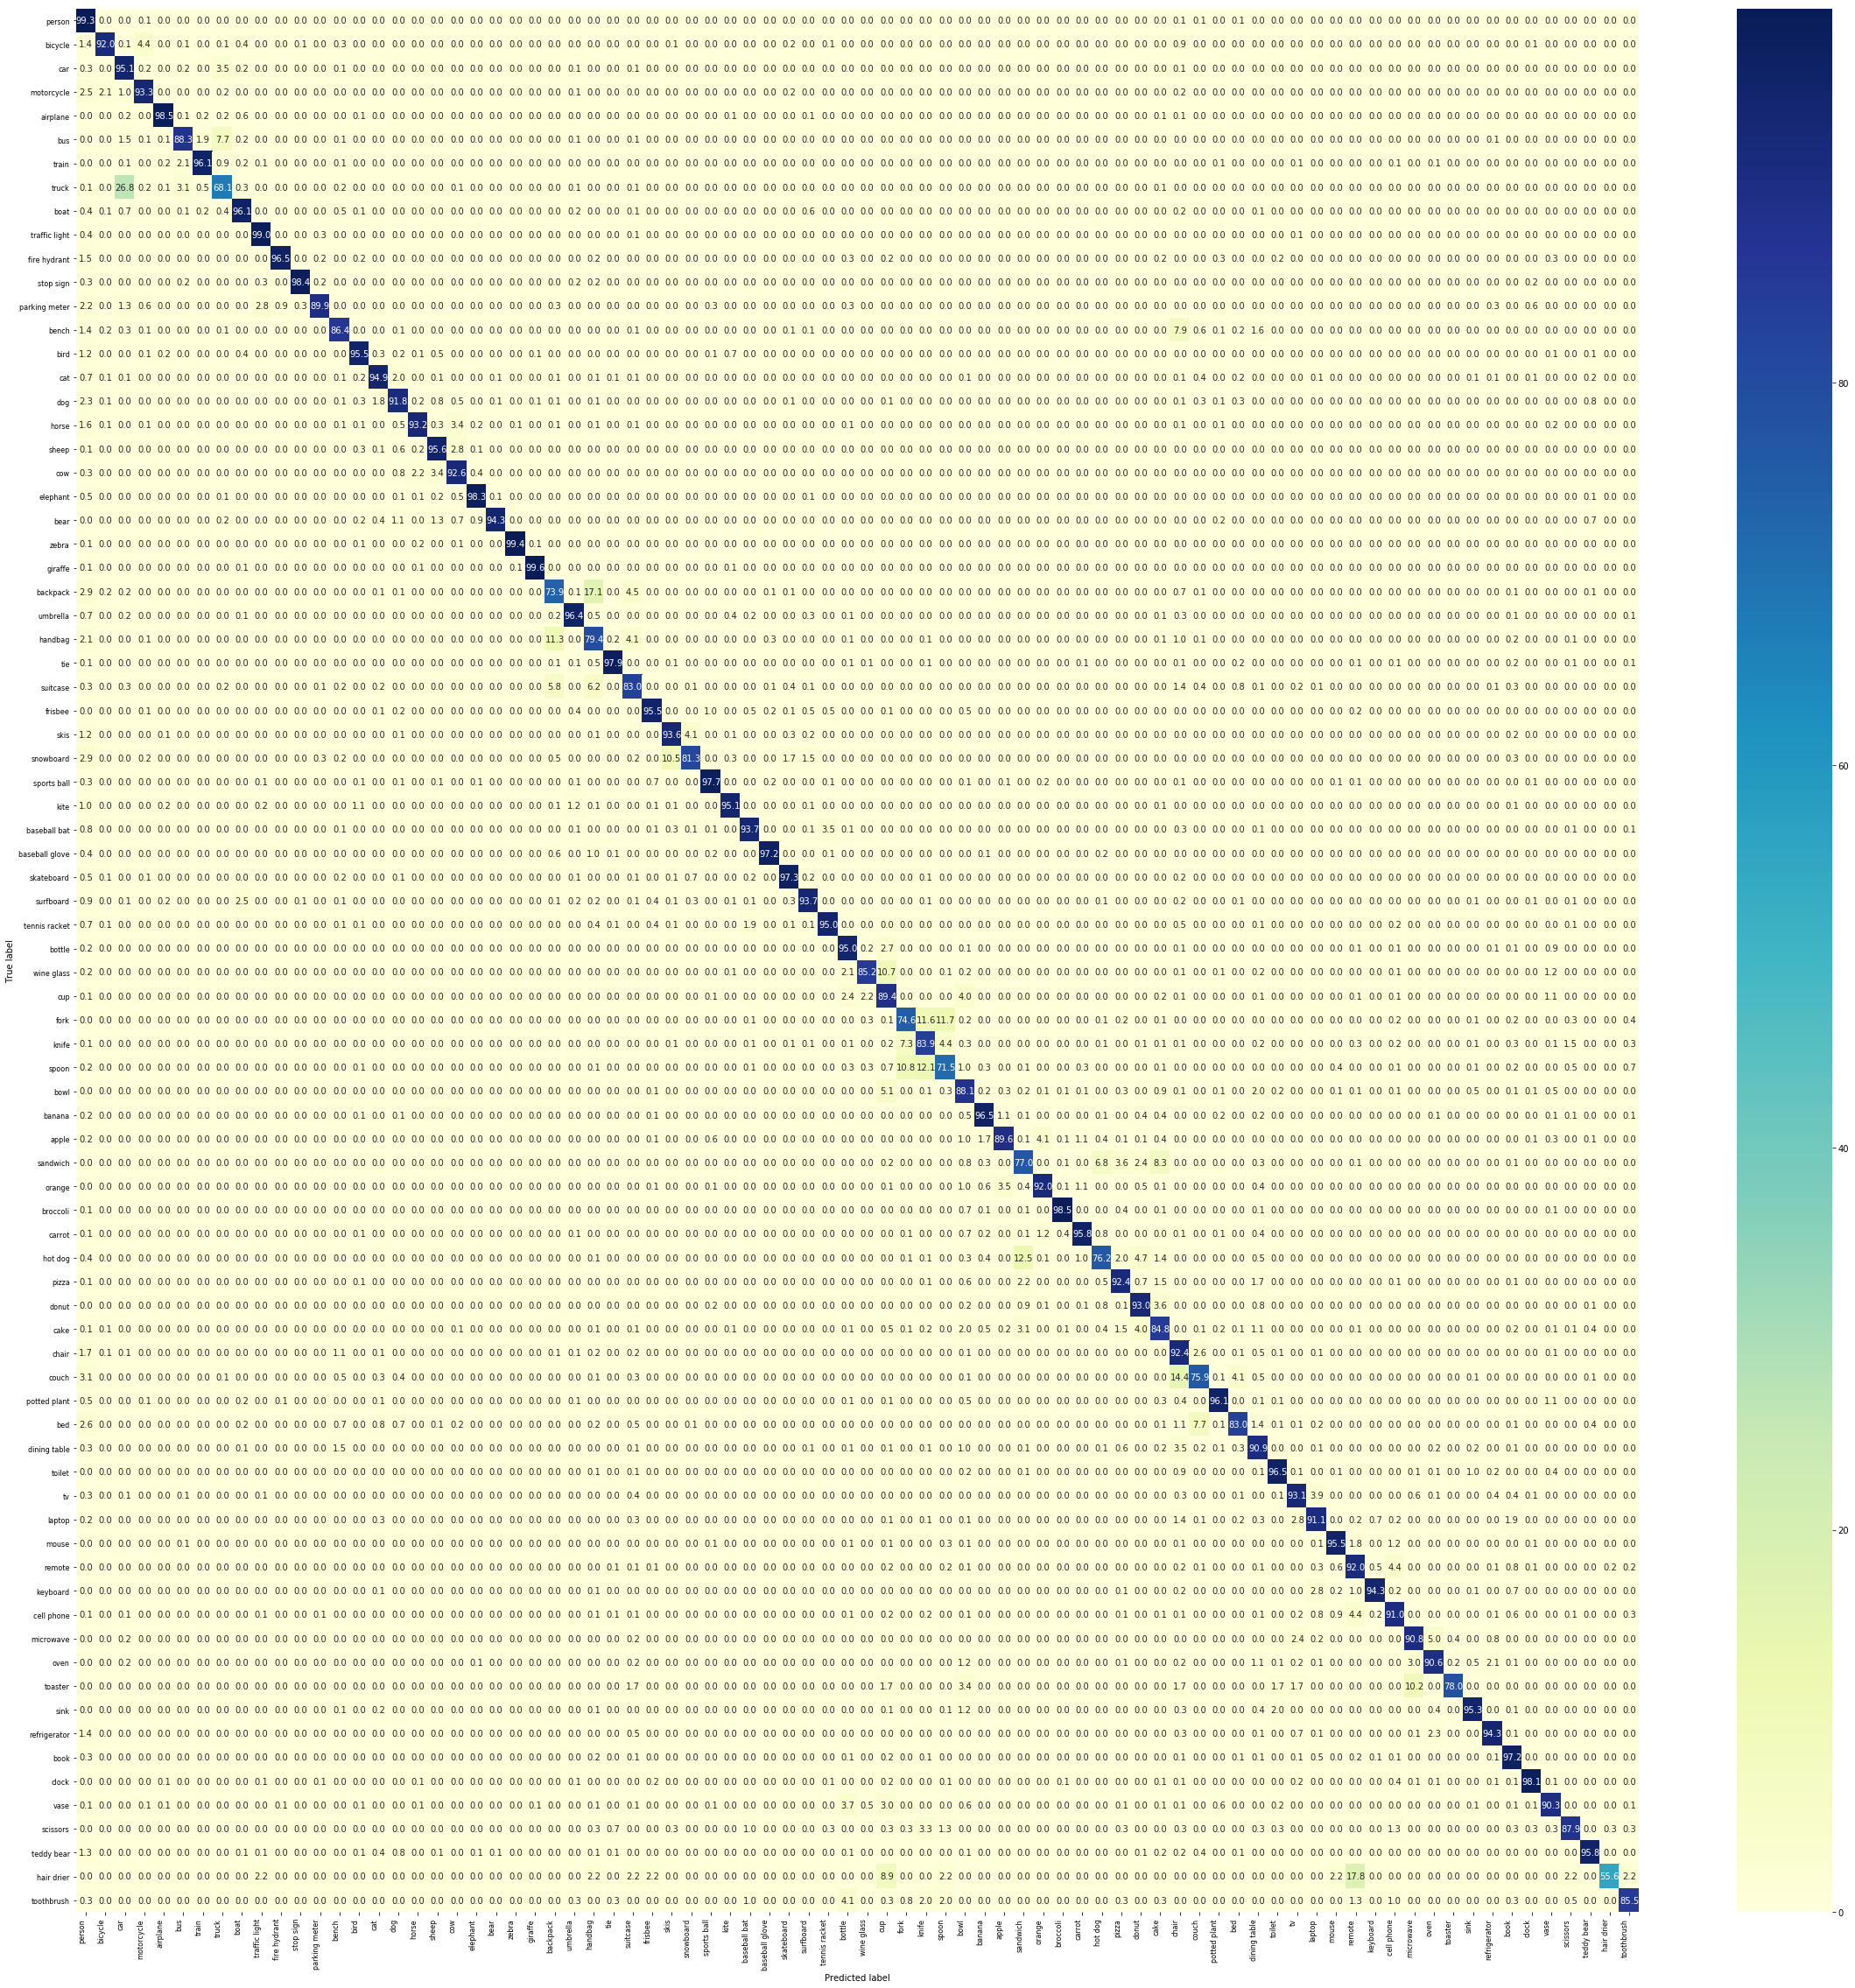

In [21]:
percentage_plot_cfmatrix(cfmatrix,class_names,iou_threshold)

### Part that calculates Missed instances, false positives etc.:

In [22]:
def elob(size,threshold,gt_container,pred_container,preds,gts,class_names):
    gtruths = []
    predictions = []
    all_gt_classes={i:0 for i in class_names}
    class_matrix={i:[0,0,0,0] for i in class_names}
    miss_matrix={k:[0] for k in class_names}
    for i in tqdm(range(size)):
        preda_bbx,pred_classes=load_boxes(i,pred_container,preds,val=True)
        gta_bbx,gt_classes=load_boxes(i,gt_container,gts)
        overlaps=compute_overlaps(np.array(preda_bbx),np.array(gta_bbx))

        match_count=0
       # discarded_2nd_bb=[]

    
        for  j in range(overlaps.shape[1]):
            all_gt_classes[class_names[gt_classes[j]]]+=1
            if overlaps.shape[0]>0:
                if overlaps[(overlaps[:, j].argmax()),j] > threshold:
                    gtruths.append((gt_classes[j]))
                    predictions.append(pred_classes[overlaps[:,j].argmax()])
                    match_count+=1
                    ### FALSE NEGATIVE

                    # MATCHED BUT WRONG PREDICTION
                    if gt_classes[j]!=pred_classes[overlaps[:,j].argmax()]:       ### 0. EŞLENİP YANLIŞ TAHMİN
                        class_matrix[class_names[gt_classes[j]]][0]+=1
                    else:
                        #TRUE POS
                        class_matrix[class_names[gt_classes[j]]][1]+=1            ### DOĞRULAR
                ##FALSE NEGATIVE
                elif overlaps[(overlaps[:, j].argmax()),j] < threshold:
                    #class_matrix[class_names[gt_classes[j]]][0]+=1
                    class_matrix[class_names[gt_classes[j]]][3]+=1                ### O GT İLE EŞLEŞEN TAHMİN YOK, MİSS
        #FALSE POS
        
        if overlaps.shape[0]>0:
            for k in range(overlaps.shape[0]):
                if overlaps[k,overlaps[k,:].argmax()] < threshold and pred_classes[k]!='BG':    #### PRED İLE EŞLEŞEN GT YOK, FALSE POS
                    class_matrix[class_names[pred_classes[k]]][2]+=1


                                         
            
                        
                            
                        
                        
                        
                    

    return gtruths,predictions,class_matrix,all_gt_classes

###  -Change Intersection of Union Threshold below

In [23]:
keyp=0
iou_threshold=0.5
a,s,class_matrix,all_gts=elob(val_total_image,iou_threshold,gt_container,pred_container,preds,gts,class_names)


  9%|▉         | 3587/40136 [00:00<00:06, 5973.96it/s]

No predictions in image:2734


 33%|███▎      | 13386/40136 [00:02<00:04, 6015.10it/s]

No predictions in image:12496


 59%|█████▉    | 23746/40136 [00:03<00:02, 5986.98it/s]

No predictions in image:22879


100%|██████████| 40136/40136 [00:06<00:00, 5965.06it/s]


In [24]:
pframe=pd.DataFrame.from_dict(class_matrix)
#frame=frameg/(frameg.iloc[[0,1,2,3]].sum())

### Order classes by their instance number:

In [25]:
real=pframe.reindex_axis((pframe.iloc[0]+pframe.iloc[1]+pframe.iloc[3]).sort_values().index, axis=1)

/home/mspr/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  """Entry point for launching an IPython kernel.


In [26]:
pframe

,BG,hair drier,toaster,scissors,bear,parking meter,microwave,toothbrush,fire hydrant,stop sign,...,handbag,traffic light,bowl,dining table,cup,bottle,book,chair,car,person
0,0,20,13,37,26,32,46,57,21,9,...,442,30,467,342,565,303,133,689,565,517
1,0,25,46,270,430,284,452,335,575,567,...,1704,2881,3465,3434,4778,5786,4653,8417,11012,72498
2,0,105,92,399,81,340,306,627,332,645,...,4079,2750,4107,5390,5097,6870,15214,11981,8269,58965
3,0,29,19,137,6,196,41,240,54,110,...,1970,1448,988,1468,1693,2291,3771,4024,3430,15099


In [27]:
number_of_instances=(pframe.iloc[[0,1,3]].sum())

In [28]:
number_of_instances

BG                    0
hair drier           74
toaster              78
scissors            444
bear                462
parking meter       512
microwave           539
toothbrush          632
fire hydrant        650
stop sign           686
snowboard           794
mouse               851
refrigerator        888
frisbee             935
hot dog            1021
baseball bat       1022
keyboard           1028
oven               1175
baseball glove     1206
airplane           1444
bed                1450
sandwich           1461
toilet             1463
teddy bear         1542
train              1602
tennis racket      1623
cat                1669
skateboard         1710
giraffe            1767
fork               1776
                  ...  
vase               2267
clock              2273
bicycle            2473
donut              2540
knife              2559
wine glass         2638
carrot             2684
broccoli           2697
cow                2839
kite               2847
backpack        

In [29]:
percentage=pframe/(pframe.iloc[[0,1,2,3]].sum())

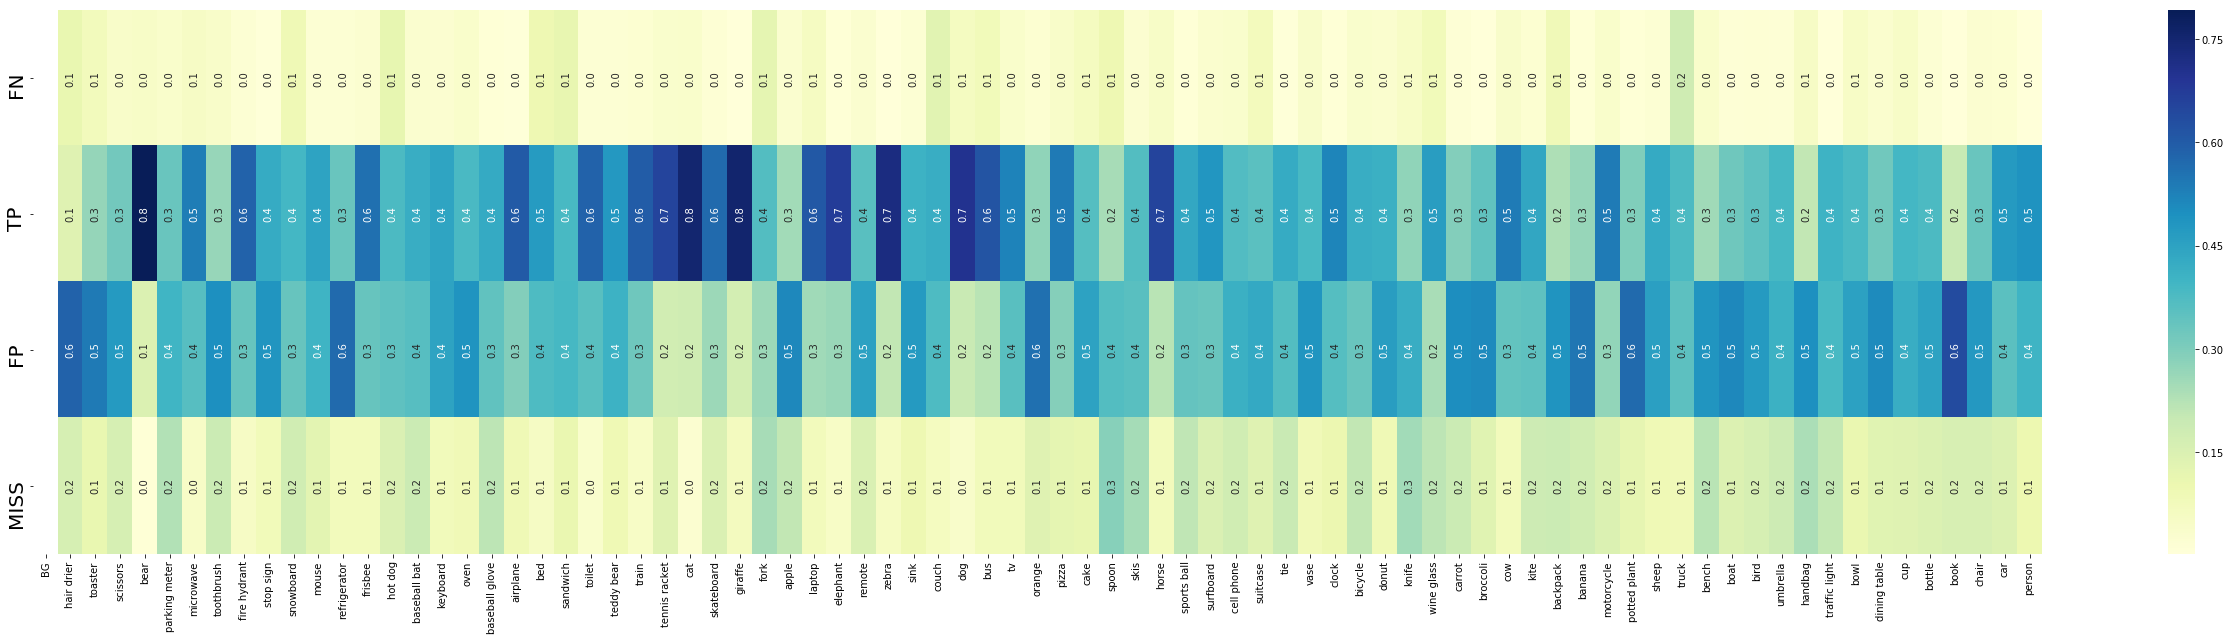

In [30]:
plt.figure(figsize=(45,10))

heatmap=sn.heatmap(percentage,annot=True,annot_kws={"rotation":90},cmap="YlGnBu",fmt='.1f')
heatmap.yaxis.set_ticklabels(["FN","TP","FP","MISS"], rotation=90, ha='right', fontsize=20),
plt.savefig("CLASS_EVALUATION_TABLE.png")


### False Positives:
####  Detection on Background.
### False Negatives:
#### -Matched locally with GT, but wrong class prediction.
#### - Fails to detect the object. 
### True Positive:
#### Matching the GT with correct class label.



### RECALL:

####  TP/(TP+FN)


### Precision:

### TP/(TP+FP)

In [31]:
def get_recall(class_matrix,class_names):
    recall=[class_matrix[i][1]/(class_matrix[i][1]+class_matrix[i][0]+class_matrix[i][3]) for i in class_names[1:]]
    return recall

In [32]:
def get_precision(class_matrix,class_names):
    
    precision=[class_matrix[i][1]/(class_matrix[i][1]+class_matrix[i][2]) for i in class_names[1:]]
    return precision

In [33]:
def get_f1_score(precision,recall):
    F1 = [(2 * (precision[k] * recall[k]) / (precision[k] + recall[k])) for k in range(len(class_names[1:]))]
    return F1

In [34]:
def overview(threshold):
    keyp=0
    gt,pred,class_matrix=elob(82080,threshold,gt_container,pred_container,preds,gts,class_names)
    recall=get_recall(class_matrix,class_names)
    precision=get_precision(class_matrix,class_names)
    f1_score=get_f1_score(precision,recall)
    sn.heatmap(f1_score)
    return recall,precision,f1_score

#### How different thresholds affects predictions:
#### Currently  IoU between 0.4-0.8

In [36]:
complete_list=[[],[],[]]
for i_threshold in range(4,8,1):
    i_threshold=i_threshold/10
    keyp=0
    a,s,class_matrix,gt_classes=elob(val_total_image,i_threshold,gt_container,pred_container,preds,gts,class_names) ### Train_total_image'ı değiştir.
    recall=get_recall(class_matrix,class_names)
    precision=get_precision(class_matrix,class_names)
    f1_score=get_f1_score(precision,recall)
    complete_list[0].append(recall)
    complete_list[1].append(precision)
    complete_list[2].append(f1_score)
    
    
    

  9%|▉         | 3617/40136 [00:00<00:07, 5156.90it/s]

No predictions in image:2734


 33%|███▎      | 13333/40136 [00:02<00:05, 5266.91it/s]

No predictions in image:12496


 59%|█████▊    | 23507/40136 [00:04<00:03, 5246.93it/s]

No predictions in image:22879


  9%|▉         | 3617/40136 [00:00<00:07, 5162.31it/s]

No predictions in image:2734


 33%|███▎      | 13243/40136 [00:02<00:05, 5217.51it/s]

No predictions in image:12496


 59%|█████▉    | 23783/40136 [00:04<00:03, 5170.96it/s]

No predictions in image:22879


  9%|▉         | 3577/40136 [00:00<00:07, 5102.84it/s]

No predictions in image:2734


 32%|███▏      | 13020/40136 [00:02<00:05, 5146.24it/s]

No predictions in image:12496


 59%|█████▉    | 23795/40136 [00:04<00:03, 5191.78it/s]

No predictions in image:22879


  9%|▉         | 3787/40136 [00:00<00:06, 5405.70it/s]

No predictions in image:2734


 33%|███▎      | 13319/40136 [00:02<00:05, 5260.42it/s]

No predictions in image:12496


 58%|█████▊    | 23469/40136 [00:04<00:03, 5071.08it/s]

No predictions in image:22879


100%|██████████| 40136/40136 [00:07<00:00, 5030.46it/s]


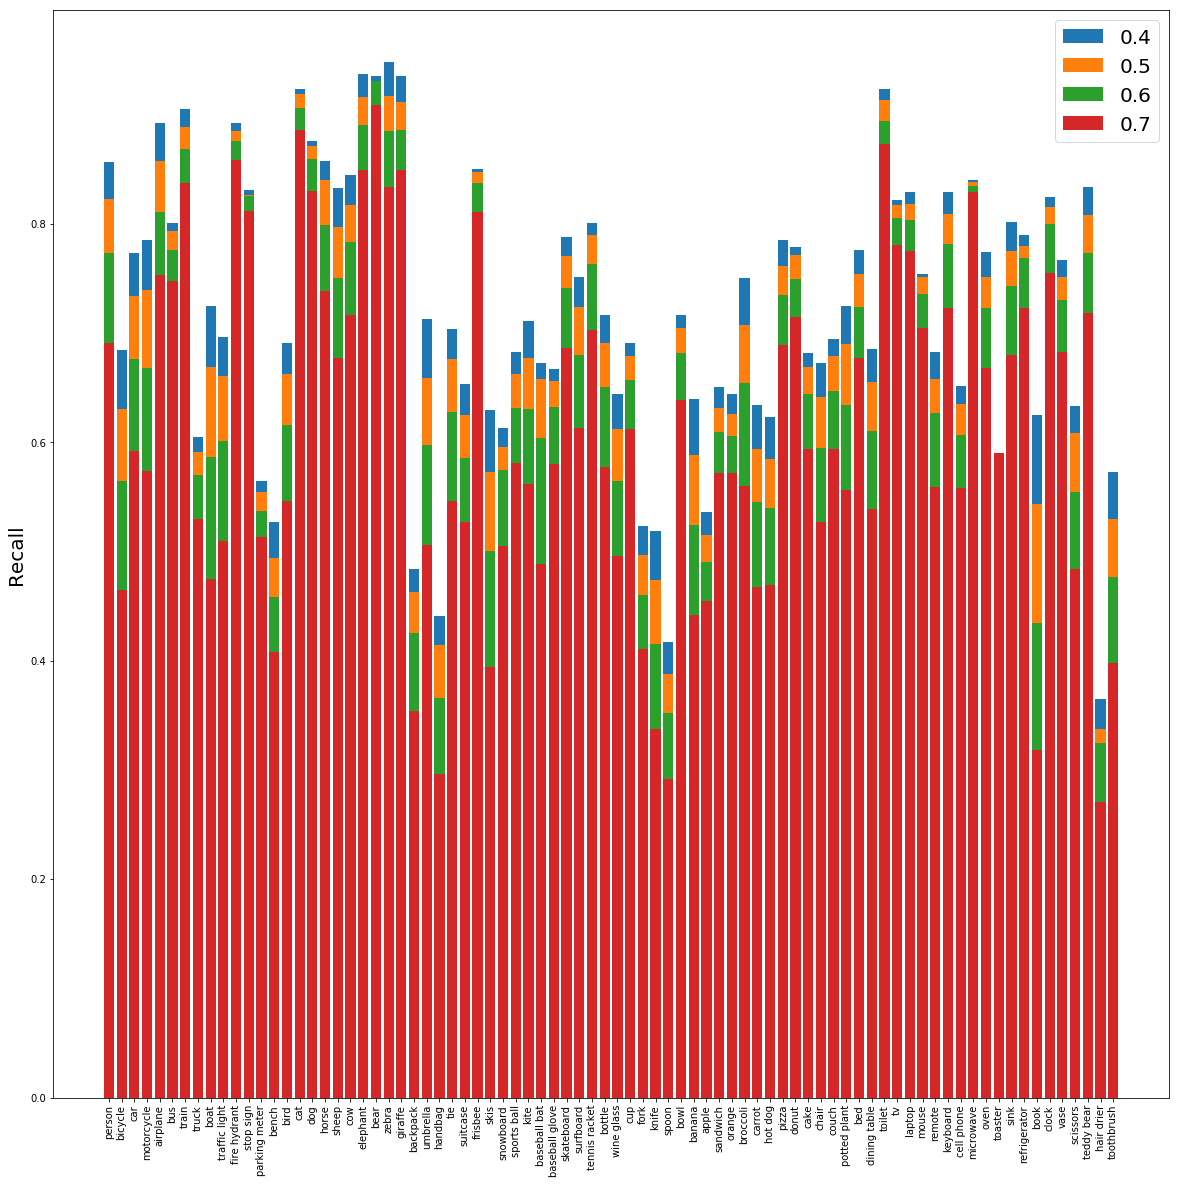

In [37]:
plt.figure(figsize=(20,20))
plt.xticks([i for i in range(80)],class_names[1:],rotation='vertical')
for i in range(len(complete_list[0])):
    plt.bar(class_names[1:],complete_list[0][i])
plt.ylabel("Recall",fontsize=20)
plt.legend(('0.4', '0.5',"0.6","0.7"),fontsize=20)
plt.savefig("0.4-0.7 Recall.png")

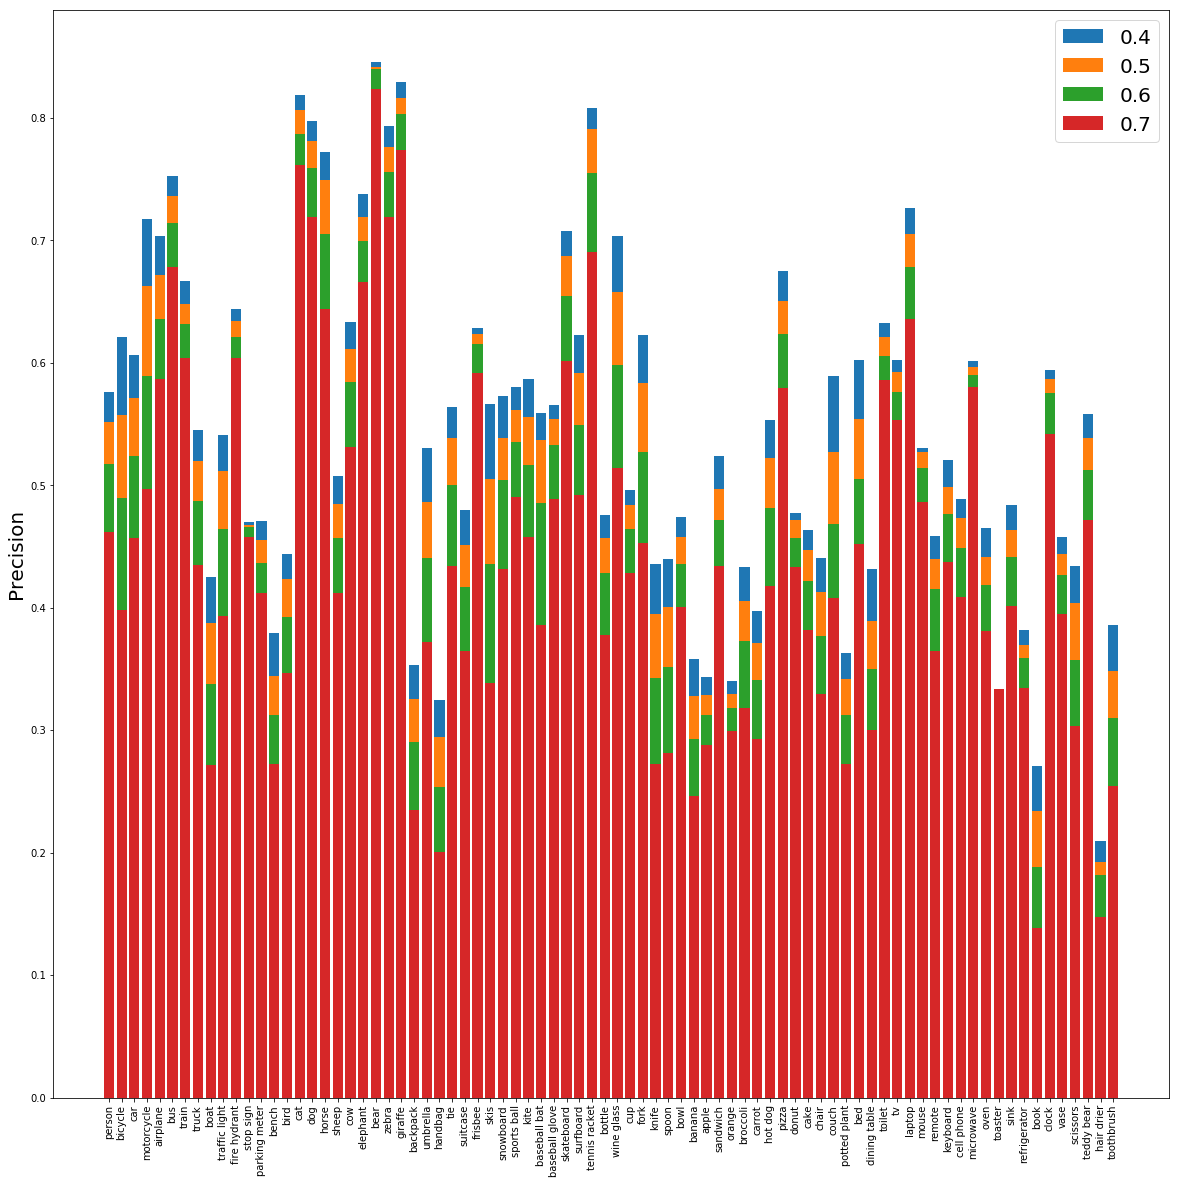

In [38]:
plt.figure(figsize=(20,20))
plt.xticks([i for i in range(80)],class_names[1:],rotation='vertical')
for i in range(len(complete_list[1])):
    plt.bar(class_names[1:],complete_list[1][i])
plt.ylabel("Precision",fontsize=20)
plt.legend(('0.4', '0.5',"0.6","0.7"),fontsize=20)
plt.savefig("0.4-0.7 Precision.png")

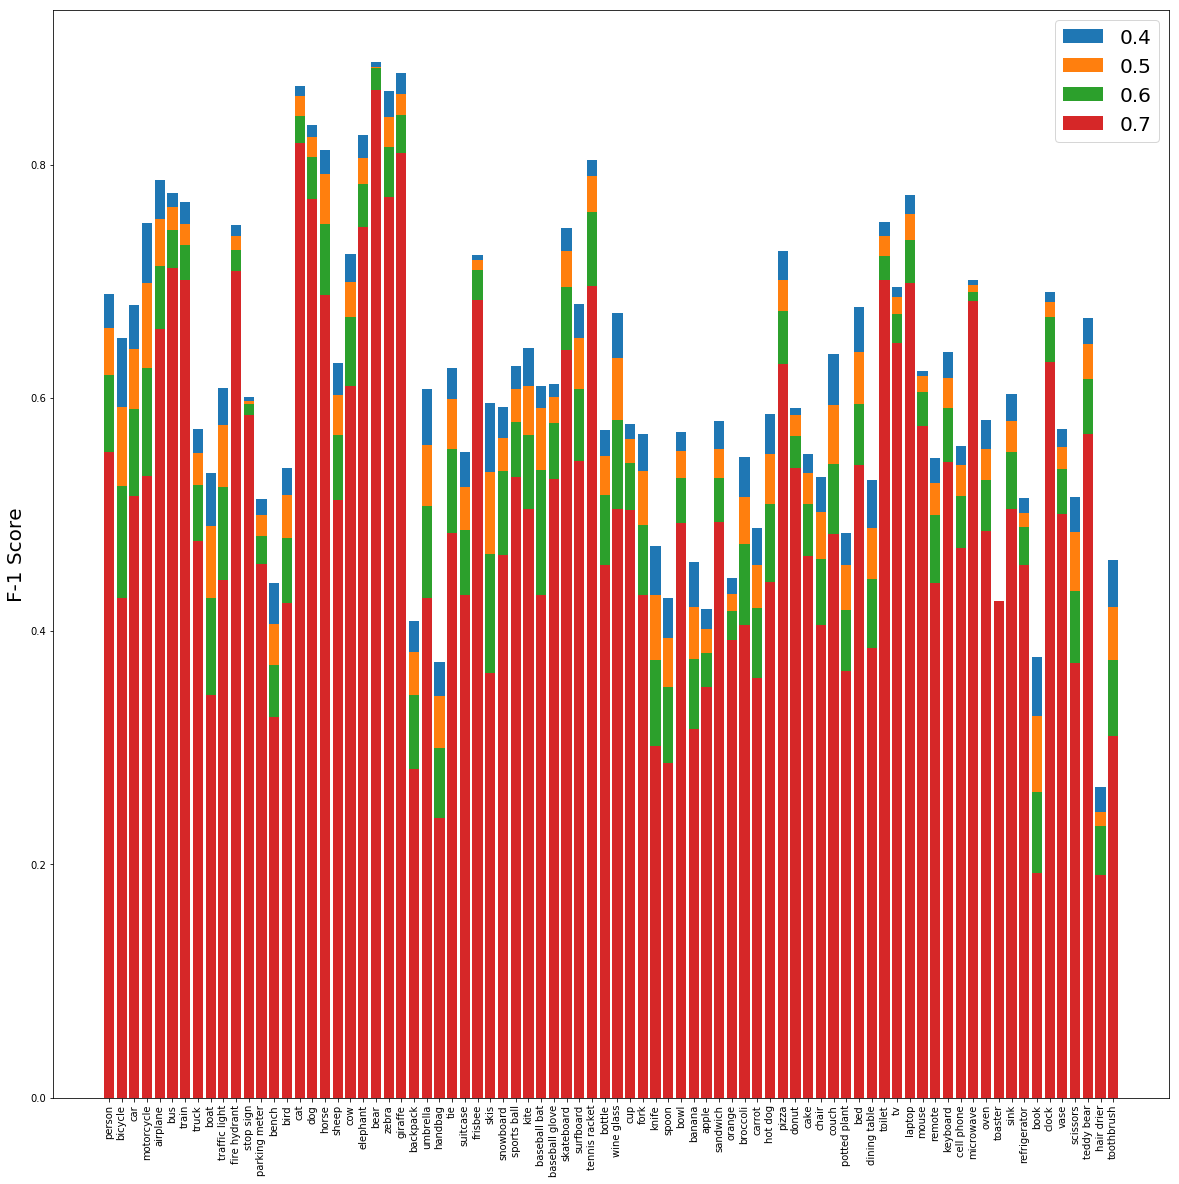

In [39]:
plt.figure(figsize=(20,20))
plt.xticks([i for i in range(80)],class_names[1:],rotation='vertical')
for i in range(len(complete_list[2])):
    plt.bar(class_names[1:],complete_list[2][i])
plt.ylabel("F-1 Score",fontsize=20)
plt.legend(('0.4', '0.5',"0.6","0.7"),fontsize=20)
plt.savefig("0.4-0.7 F-1 Score.png")

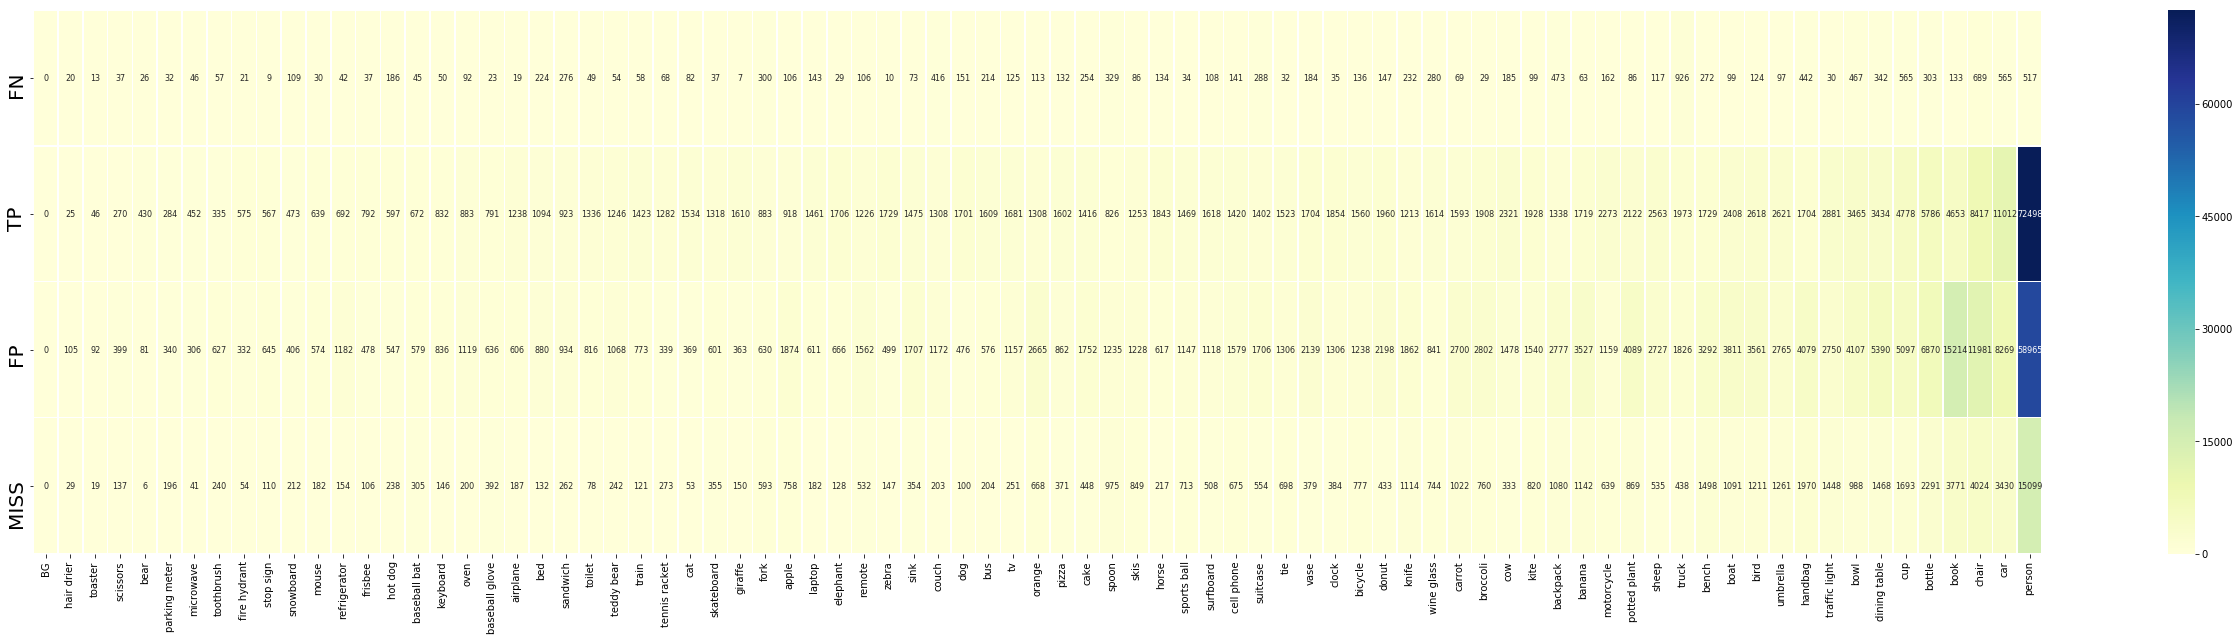

In [40]:
plt.figure(figsize=(45,10))

heatmap=sn.heatmap(real,annot=True,cmap="YlGnBu",fmt='d',annot_kws={'size':8},linewidths=.5)

heatmap.yaxis.set_ticklabels(["FN","TP","FP","MISS"], rotation=90, ha='right', fontsize=20),
plt.savefig("TopPerforming.png")

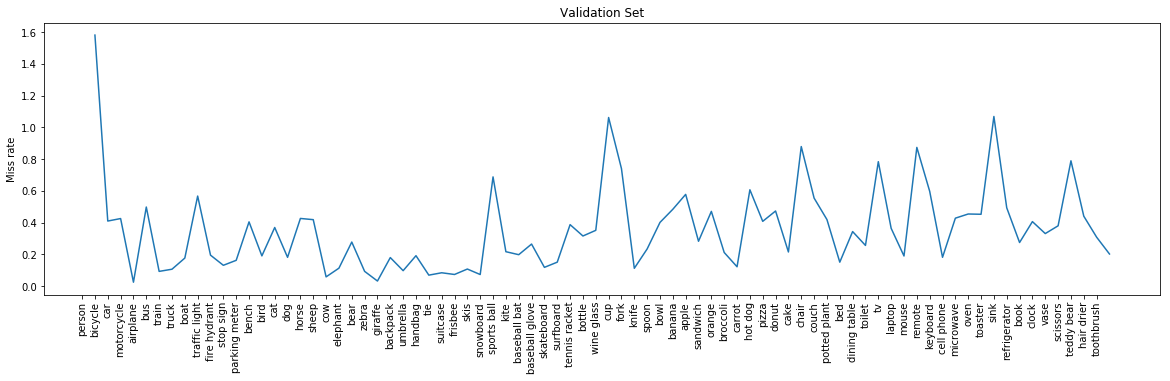

In [108]:
plt.figure(figsize=(20,5))
plt.plot((real.iloc[3]/(real.iloc[1])))
plt.xticks([i for i in range(80)],class_names[1:],rotation='vertical');

plt.title("Validation Set")
plt.ylabel("Miss rate")
plt.savefig("Val-Comparison.png")


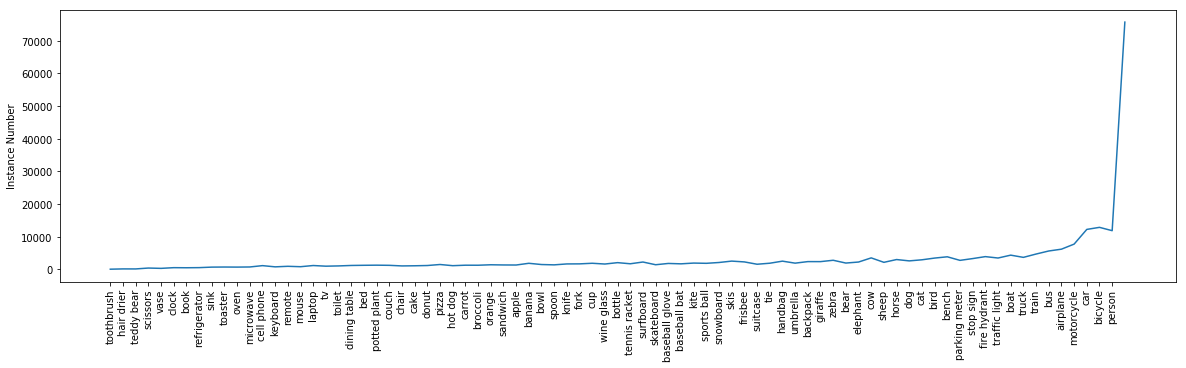

In [114]:
plt.figure(figsize=(20,5))
plt.plot(real.mean());
plt.ylabel("Instance Number")
plt.xticks([i for i in range(80)],(class_names[1:]),rotation='vertical');
